## Analyze A/B Test Results by Michelle Petersen

## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)

<a id='intro'></a>
### Introduction

The goal of this project is to understand the results of an A/B test run by an e-commerce website. This resuls will help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

<a id='probability'></a>
#### Part I - Probability

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline

#Set the seed
random.seed(42)

In [2]:
# Read in ab_data.csv 
df = pd.read_csv('ab_data.csv')

# Examine the first five rows
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [3]:
# Examine size of the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
user_id         294478 non-null int64
timestamp       294478 non-null object
group           294478 non-null object
landing_page    294478 non-null object
converted       294478 non-null int64
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


In [4]:
# Examine statistics
df.describe()

,user_id,converted
count,294478.000000,294478.000000
mean,787974.124733,0.119659
std,91210.823776,0.324563
min,630000.000000,0.000000
25%,709032.250000,0.000000
50%,787933.500000,0.000000
75%,866911.750000,0.000000
max,945999.000000,1.000000


In [5]:
# Examine number of unique users
unique_users = df["user_id"].nunique()
unique_users

290584

##### The proportion of users converted:

In [6]:
df_converted = df.query("converted == 1")
print("Number of converted rows: \n" + str(df_converted.count()[0]))
print("\nNumber of unique converted users: " + str(df_converted["user_id"].nunique()))
print("Proportion of unique converted users: " + str(df_converted["user_id"].nunique() / unique_users))   

Number of converted rows: 
35237

Number of unique converted users: 35173
Proportion of unique converted users: 0.12104245244060237


##### The number of times the `new_page` and `treatment` don't line up:

In [7]:
df_mismatch1 = df.loc[(df['group'] == 'control') & (df['landing_page'] != 'old_page')]
print("Mismatch in control group: \n" + str(df_mismatch1.count()[0]))
df_mismatch2 = df.loc[(df['group'] == 'treatment') & (df['landing_page'] != 'new_page')]
print("\nMismatch in treatment group: \n" + str(df_mismatch2.count()[0]))
print("\nTotal Mismatch: \n" + str(df_mismatch1.count()[0] + df_mismatch2.count()[0]))

Mismatch in control group: 
1928

Mismatch in treatment group: 
1965

Total Mismatch: 
3893


##### Rows with missing values

In [8]:
print("Number of missing values: \n" + str(df.isnull().sum(axis = 0)))

Number of missing values: 
user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64


##### Create a new dataframe df2 that combines a treatment and control dataframe.   The treatment received the new page and control received the old page

In [9]:
df_control = df.loc[((df['group'] == 'control') & (df['landing_page'] == 'old_page'))] 
df_treatment = df.loc[((df['group'] == 'treatment') & (df['landing_page'] == 'new_page'))] 
df2 = pd.concat([df_control, df_treatment])     
df2.tail()

,user_id,timestamp,group,landing_page,converted
294462,677163,2017-01-03 19:41:51.902148,treatment,new_page,0
294465,925675,2017-01-07 20:38:26.346410,treatment,new_page,0
294468,643562,2017-01-02 19:20:05.460595,treatment,new_page,0
294472,822004,2017-01-04 03:36:46.071379,treatment,new_page,0
294477,715931,2017-01-16 12:40:24.467417,treatment,new_page,0


In [10]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

##### Number of unique user_id's that are in df2

In [11]:
unique_df2_users = df2["user_id"].nunique()
unique_df2_users

290584

##### Detect if there are duplicate user_id's

In [12]:
duplicated_df = df2.loc[df2['user_id'].duplicated() == True]

##### Print duplicate user_id's

In [13]:
print(duplicated_df)

      user_id                   timestamp      group landing_page  converted
2893   773192  2017-01-14 02:55:59.590927  treatment     new_page          0


##### Remove **one** of the rows with a duplicate **user_id**

In [14]:
df2 = df2.drop_duplicates(subset=['user_id'], keep='last')

In [15]:
# Test that the duplicate was removed
duplicated_df = df2.loc[df2['user_id'].duplicated() == True]
print(duplicated_df)

Empty DataFrame
Columns: [user_id, timestamp, group, landing_page, converted]
Index: []


##### The probability of an individual converting regardless of the page they receive:

In [16]:
df_converted = df2.loc[df2['converted'] == 1]
print("Total number of user conversions: \n" + str(df_converted.count()[0]))
print("\nProbability of a user conversion: \n" + str(df_converted.count()[0] / df2.count()[0]))

Total number of user conversions: 
34753

Probability of a user conversion: 
0.11959708724499628


##### Probability of an that an individual was in the `control` group converting:

In [17]:
df_control = df2.loc[(df2['group'] == 'control')]
print("Total number in control group: " + str(df_control.count()[0]))
df_control_converted = df_control.loc[(df_control['converted'] == 1)]
print("Total number converted in the control group: " + str(df_control_converted.count()[0]))
prob_conversions_control = df_control_converted.count()[0] / df_control.count()[0]
print("\nProbability of user conversion in control group: \n" + str(prob_conversions_control))

Total number in control group: 145274
Total number converted in the control group: 17489

Probability of user conversion in control group: 
0.1203863045004612


##### Probability of an that an individual was in the `treatment` group converting:

In [18]:
df_treatment = df2.loc[(df2['group'] == 'treatment')]
print("Total number in treatment group: " + str(df_treatment.count()[0]))
df_treatment_converted = df_treatment.loc[(df_treatment['converted'] == 1)]
print("Total number converted in the treatment group: " + str(df_treatment_converted.count()[0]))
prob_conversions_treatment = df_treatment_converted.count()[0] / df_treatment.count()[0]
print("\nProbability of user conversion in treatment group: \n" + str(prob_conversions_treatment))

Total number in treatment group: 145310
Total number converted in the treatment group: 17264

Probability of user conversion in treatment group: 
0.11880806551510564


##### Probability that an individual received the new page:

In [19]:
df_new_page = df2.loc[(df2['landing_page'] == 'new_page')]
print("Probability of user seeing the new page: \n" + str(df_new_page.count()[0] / df2.count()[0]))

Probability of user seeing the new page: 
0.5000619442226688


**The difference between the user conversion probability of the two groups is 0.001578 in favor of keeping the old page. Based on the analysis thus far, we fail to reject the null hypothesis.**

<a id='ab_test'></a>
### Part II - A/B Test

I assume  the old page is better, unless the new page proves to be better with a Type I error rate of 5%. 

My null and alternative hypothesis are:

**H0: $p_{new}$ <= $p_{old}$**

**H1: $p_{new}$ > $p_{old}$**

**The null hypothesis: the new page generates a conversion rate less than or equal to the old page.**

**The alternative hypothesis: the new page generates a conversion rate greater than the old page.**

`Assumptions:` under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

##### **Convertion rate** for $p_{new}$ under the null:

In [20]:
p_new = df2['converted'].mean()
p_new

0.11959708724499628

#####  **Convertion rate** for $p_{old}$ under the null:

In [21]:
p_old = df2['converted'].mean()
p_old

0.11959708724499628

##### $n_{new}$:

In [22]:
df_treatment = df2.loc[(df2['group'] == 'treatment')]
n_new = df_treatment.count()[0]
n_new

145310

##### $n_{old}$:

In [23]:
df_control = df2.loc[(df2['group'] == 'control')]
n_old = df_control.count()[0]
print(n_old)

145274


In [24]:
# Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null. Store $n_{new}$ 1's and 0's in dataframe new_page_converted.
new_page_converted =  np.random.choice([0,1], n_new, p=(p_new, 1-p_new))
new_page_converted

array([0, 0, 1, ..., 1, 1, 1])

In [25]:
#Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null. 
# Store $n_{old}$ 1's and 0's in old_page_converted.
old_page_converted = np.random.choice([0,1], n_old, p=(p_old, 1-p_old))
old_page_converted

array([1, 1, 0, ..., 1, 1, 1])

$p_{new}$ - $p_{old}$ for simulated values:

In [26]:
simulated_difference = new_page_converted.mean() - old_page_converted.mean()
simulated_difference

0.0008280793296222555

In [27]:
# Simulate 10,000 $p_{new}$ - $p_{old}$ values. Store all 10,000 values in a numpy array called p_diffs.
p_diffs = []
size = df2.shape[0]

for _ in range(10000):
    new_page_converted = np.random.choice([0,1], n_new, p=(p_new, 1-p_new))
    old_page_converted = np.random.choice([0,1], n_old, p=(p_old, 1-p_old))
    p_diffs.append(new_page_converted.mean() - old_page_converted.mean())

##### Histogram of the p_diffs:

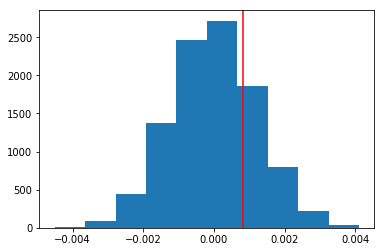

In [28]:
#convert to an array
p_diffs = np.array(p_diffs)
plt.hist(p_diffs);
plt.axvline(x=simulated_difference, color="red");

Proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**:

In [29]:
actual_diffs = df2.query('group == "treatment"')['converted'].mean() - df2.query('group == "control"')['converted'].mean()
p_val = (p_diffs > actual_diffs).mean()
p_val

0.9032

**The p-value is the probability of observing a statistic (or one more extreme in favor of the alternative) if the null hypothesis is true. Given the high value of .907 we fail to reject the null hypothesis of $p_{new}$ <= $p_{old}$. Based on the data, there isn't a difference between the old and new pages that would suggest using the new page.**

The number of conversions for each page, as well as the number of individuals who received each page. `n_old` and `n_new` refer to the number of rows associated with the old page and new pages, respectively.**

In [30]:
import statsmodels as sm
from statsmodels import api
from scipy.stats import norm

old_page = df2.loc[df2['landing_page'] == 'old_page']
new_page = df2.loc[df2['landing_page'] == 'new_page']
n_old = old_page.count()[0]
n_new = new_page.count()[0]
converted_old_page = df2.loc[((df2['converted'] == True) & (df2['landing_page'] == 'old_page'))]
converted_new_page = df2.loc[((df2['converted'] == True) & (df2['landing_page'] == 'new_page'))]
n_old_converted = converted_old_page.count()[0]
n_new_converted = converted_new_page.count()[0]

##### Compute test statistic and p-value:

In [31]:
count = np.array([n_old_converted, n_new_converted])
nobs = np.array([n_old, n_new])
value = .05
z_score, p_value = sm.stats.proportion.proportions_ztest(count, nobs, alternative='two-sided', prop_var=value)
print("z-score: " + str(z_score))
print("p_value: " + str(p_value))

print(norm.cdf(z_score))
# 0.9745180882999716 # Tells us how significant our z-score is

print(norm.ppf(1-(0.05/2)))
# 1.959963984540054 # Tells us what our critical value at 95% confidence is

z-score: 1.951784263281866
p_value: 0.05096382340005697
0.9745180882999716
1.959963984540054


**Since the z-score of 1.951784263281866 does not exceed the value of 1.959963984540054, we fail to reject the null hypothesis that the difference between the two proportions is no different from zero.**

**The new landing page is not statistically different and better than the old landing page. This agrees with our finding in k.**

<a id='regression'></a>
### Part III - Logistic regression 


**We will be using Logistic Regression.**

In [32]:
df2['ab_page'] = pd.get_dummies(df2['group'])['treatment']
df2[['doesnt_convert', 'converts']] = pd.get_dummies(df2['converted'])
df2 = df2.drop('doesnt_convert', axis=1)
df2['intercept'] = 1
print(df2['converts'].mean())
print(df2['ab_page'].mean())

0.11959708724499628
0.5000619442226688


In [33]:
# Use statsmodels to import the regression model
log_mod = sm.api.Logit(df2['converts'], df2[['intercept', 'ab_page']])
results = log_mod.fit()

Optimization terminated successfully.
         Current function value: 448.424145
         Iterations 6


### Summary:

In [34]:
results.summary()

/Users/michellepetersen/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/michellepetersen/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/michellepetersen/anaconda3/lib/python3.6/site-packages/statsmodels/discrete/discrete_model.py:3313: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.llf/self.llnull


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               converts   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Thu, 24 Jan 2019   Pseudo R-squ.:                     inf
Time:                        16:59:36   Log-Likelihood:            -1.3030e+08
converged:                       True   LL-Null:                        0.0000
                                        LLR p-value:                     1.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

In [35]:
print(np.exp(-0.0150))
print(1/np.exp(-0.0150))

0.9851119396030626
1.015113064615719


**It is a good idea to add other factors to a regression model to determine if there are multiple influences on the the AB test result.  A potential disadvantage is multicollinearity - independent variables in a regression model are correlated. A goal of regression analysis is to isoloate the relationships between each independent variable. One solution is to calculate the VIFs for each variable in the model to determine if they are correlated. If one or more of the independent variables are correlated we can remove them from the model and recompute.**

In [36]:
countries_df = pd.read_csv('./countries.csv')
df2_new = countries_df.set_index('user_id').join(df2.set_index('user_id'), how='inner')
df2_new['country'].value_counts()

US    203619
UK     72466
CA     14499
Name: country, dtype: int64

In [37]:
# Create the necessary dummy variables
df2_new[['UK', 'US', 'CA']] = pd.get_dummies(df2_new['country'])
df2_new.head()

,country,timestamp,group,landing_page,converted,ab_page,converts,intercept,UK,US,CA
user_id,,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,0,0,1,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,0,1,0,0,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,1,0,1,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,0,0,1,0,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,0,1,0,1,0


In [38]:
### Fit the Linear Model And Obtain the Results
df2_new['intercept'] = 1

log_mod = sm.api.Logit(df2_new['converted'], df2_new[['intercept', 'ab_page', 'UK', 'CA']])
results = log_mod.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Thu, 24 Jan 2019   Pseudo R-squ.:               2.323e-05
Time:                        16:59:37   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1760
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9794      0.013   -155.415      0.000      -2.004      -1.954
ab_page       -0.0149      0.011     -1.307      0.191      -0.037       0.007
UK            -0.0506      0.028     -1.784      0.074      -0.106       0.005
CA            -0.0099      0.013     -0.743      0.457      -0.036       0.016
==============================================================================
"""

In [39]:
np.exp(results.params)

intercept    0.138154
ab_page      0.985168
UK           0.950621
CA           0.990165
dtype: float64

In [40]:
1/np.exp(results.params)

intercept    7.238314
ab_page      1.015056
UK           1.051944
CA           1.009932
dtype: float64

In [41]:
df2_new.groupby('country').mean()['converted']

country
CA    0.115318
UK    0.120594
US    0.119547
Name: converted, dtype: float64

<a id='conclusions'></a>
## Conclusion

If a user was in the US they were 1.05 more likely to convert than if they were from the UK. If a user was in the US they are 1.01 times more likely to convert than if they were in CA. US users are slightly more likely to convert.